<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-1-1e6e32f09a96>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cpu


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

In [ ]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


Deep CNNs on ImageNet
For our experiments in this notebook, we will use common CNN architectures trained on the ImageNet dataset. Such models are luckily provided by PyTorch's torchvision package, and hence we just need to load the model of our preference. For the results on the website and default on Google Colab, we use a ResNet34. Feel free to experiment with other architectures as well, the code is mainly independent of the specific architecture we choose.

In [ ]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s]


To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset (note that this dataset is shared under the same license as the original ImageNet dataset). Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [ ]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Before we start with our attacks, we should verify the performance of our model. As ImageNet has 1000 classes, simply looking at the accuracy is not sufficient to tell the performance of a model. Imagine a model that always predicts the true label as the second-highest class in its softmax output. Although we would say it recognizes the object in the image, it achieves an accuracy of 0. In ImageNet with 1000 classes, there is not always one clear label we can assign an image to. This is why for image classifications over so many classes, a common alternative metric is "Top-5 accuracy", which tells us how many times the true label has been within the 5 most-likely predictions of the model. As models usually perform quite well on those, we report the error (1 - accuracy) instead of the accuracy:

In [ ]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

The ResNet34 achives a decent error rate of 4.3% for the top-5 predictions. Next, we can look at some predictions of the model to get more familiar with the dataset. The function below plots an image along with a bar diagram of its predictions. We also prepare it to show adversarial examples for later applications.

In [ ]:

_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


In [ ]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Let's visualize a few images below:

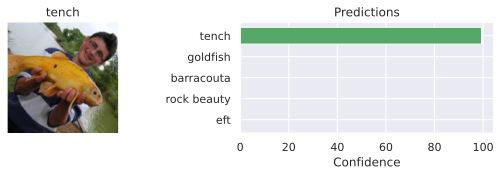

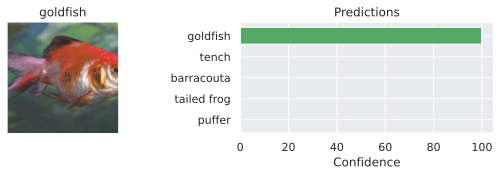

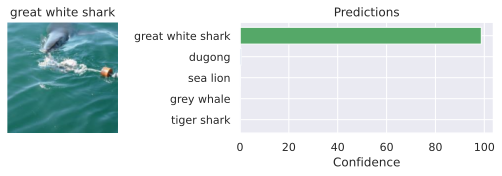

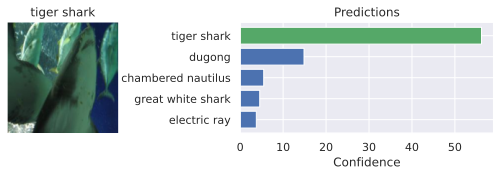

In [ ]:

exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

For simplicity, we will only focus on making the patch robust to the location in the image. Given a batch of input images and a patch, we can add the patch as follows:

In [ ]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

The patch itself will be an nn.Parameter whose values are in the range between
 and
. Images are, however, naturally limited in their range, and thus we write a small function that maps the parameter into the image value range of ImageNet:

In [ ]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

Before looking at the actual training code, we can write a small evaluation function. We evaluate the success of a patch by how many times we were able to fool the network into predicting our target class. A simple function for this is implemented below.

In [ ]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Finally, we can look at the training loop. Given a model to fool, a target class to design the patch for, and a size
 of the patch in the number of pixels, we first start by creating a parameter of size
. These are the only parameters we will train, and the network itself remains untouched. We use a simple SGD optimizer with momentum to minimize the classification loss of the model given the patch in the image. While we first start with a very high loss due to the good initial performance of the network, the loss quickly decreases once we start changing the patch. In the end, the patch will represent patterns that are characteristic of the class. For instance, if we would want the model to predict a "goldfish" in every image, we would expect the pattern to look somewhat like a goldfish. Over the iterations, the model finetunes the pattern and, hopefully, achieves a high fooling accuracy.

In [ ]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

To get some experience with what to expect from an adversarial patch attack, we want to train multiple patches for different classes. As the training of a patch can take one or two minutes on a GPU, we have provided a couple of pre-trained patches including their results on the full dataset. The results are saved in a JSON file, which is loaded below.

In [ ]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

Additionally, we implement a function to train and evaluate patches for a list of classes and patch sizes. The pretrained patches include the classes toaster, goldfish, school bus, lipstick, and pineapple. We chose the classes arbitrarily to cover multiple domains (animals, vehicles, fruits, devices, etc.). We trained each class for three different patch sizes:
 32 * 32pixels,
 48 * 48pixels, and
 64 * 64pixels. We can load them in the two cells below.

In [ ]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

Add banana to train

In [ ]:

class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple', 'banana']
patch_sizes = [32, 48]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

<ipython-input-14-ec2bc4062290>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(file_name)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/data

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for banana and 32: {'acc': 0.5390781760215759, 'top5': 0.7835671305656433}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for banana and 48: {'acc': 0.0, 'top5': 0.008999999612569809}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Before looking at the quantitative results, we can actually visualize the patches.

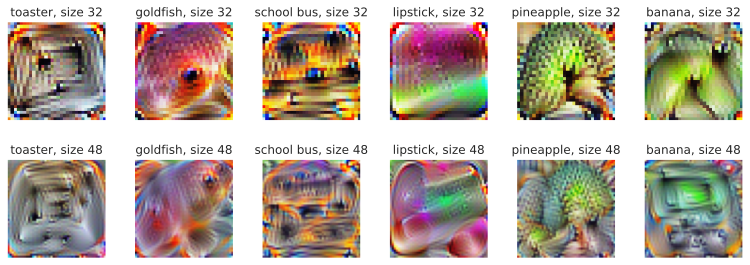

In [ ]:
from scipy.ndimage import zoom
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
            # Save the patch for cname 'banana' and psize 32
            if cname == "banana" and psize == 32:
                # Adjust the size of the image, e.g., 512x512
                target_size = (512, 512)
                zoom_factors = (target_size[0] / patch.shape[0], target_size[1] / patch.shape[1], 1)
                resized_patch = zoom(patch, zoom_factors, order=1)  # Resize the image
                plt.imsave(f"{cname}_patch_size_{psize}.png", resized_patch)
            if cname == "banana" and psize == 48:
                # Adjust the size of the image, e.g., 512x512
                target_size = (512, 512)
                zoom_factors = (target_size[0] / patch.shape[0], target_size[1] / patch.shape[1], 1)
                resized_patch = zoom(patch, zoom_factors, order=1)  # Resize the image
                plt.imsave(f"{cname}_patch_size_{psize}.png", resized_patch)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

Finally, let's create some example visualizations of the patch attack in action.

In [ ]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])



The result of 32*32 patch of banana is not good. So I will improve the results by creative components.

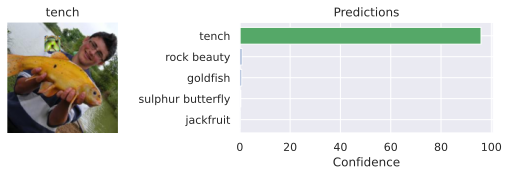

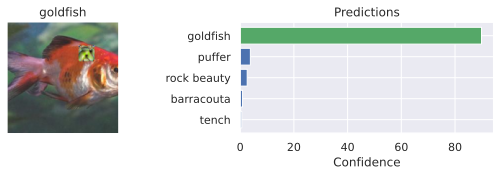

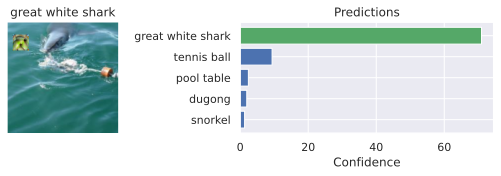

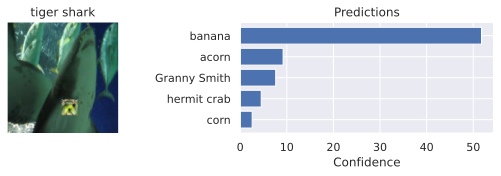

In [ ]:
perform_patch_attack(patch_dict['banana'][32]['patch'])

My idea is combining the 32 * 32 and 48 * 48 patchs for banana. Using the combined patch to be the start point and train.

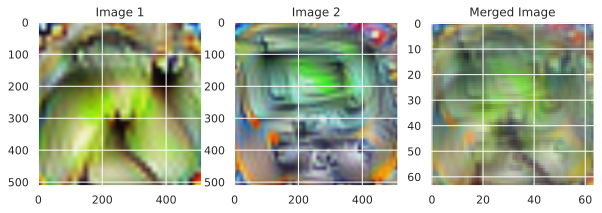

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

def show_merged_images(img1_path, img2_path, patch_size=(64, 64)):
    # Load images
    img1 = Image.open(img1_path).convert('RGB')
    img2 = Image.open(img2_path).convert('RGB')

    # Define transformation: resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize(patch_size),
        transforms.ToTensor()
    ])

    # Transform images to tensors
    img1_tensor = transform(img1)
    img2_tensor = transform(img2)

    # Combine images (average them)
    combined_img = (img1_tensor + img2_tensor) / 2

    # Convert combined image back to numpy for display
    combined_img_np = combined_img.permute(1, 2, 0).numpy()

    # Display the images
    plt.figure(figsize=(10, 5))

    # Original images
    plt.subplot(1, 3, 1)
    plt.imshow(img1)
    plt.title('Image 1')

    plt.subplot(1, 3, 2)
    plt.imshow(img2)
    plt.title('Image 2')

    # Merged image
    plt.subplot(1, 3, 3)
    plt.imshow(combined_img_np)
    plt.title('Merged Image')

    plt.show()

show_merged_images('/content/banana_patch_size_32.png', '/content/banana_patch_size_48.png', patch_size=(64, 64))


In [ ]:
# New Idea(creative component)
# My idea is combining the 32*32 and 48*48 patchs for banana. Using the combined patch to be the start point and train.
# 2 epochs to avoid overfitting
def new_patch_attack(model, target_class = label_names.index('banana'), patch_size=64, num_epochs=2, img1_path='/content/banana_patch_size_32.png', img2_path='/content/banana_patch_size_48.png'):
    # Leave a small set of images out to check generalization
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)

    # Load and process images to create an initial patch
    if img1_path and img2_path:
        # Load images
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        # Define transformation: resize and convert to tensor
        transform = transforms.Compose([
            transforms.Resize(patch_size),
            transforms.ToTensor()
        ])

        # Transform images to tensors
        img1_tensor = transform(img1)
        img2_tensor = transform(img2)

        # Combine images
        patch = (img1_tensor + img2_tensor) / 2


    # Ensure patch is a trainable parameter
    patch = nn.Parameter(patch, requires_grad=True)

    # Optimizer and loss
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}


In [ ]:
merge_patch_data, result = new_patch_attack(pretrained_model)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
result

{'acc': 0.9639999866485596, 'top5': 0.9984999895095825}

In [ ]:
merge_patch_data

tensor([[[ 0.7856,  0.5269,  0.4756,  ...,  0.2079,  0.8074,  0.8917],
         [ 0.1006,  0.0056,  0.3248,  ...,  0.1377,  0.3794,  0.9355],
         [-0.0501,  0.0741,  0.2254,  ...,  0.3643,  0.1569,  0.3367],
         ...,
         [ 0.4333,  0.3932,  0.4883,  ...,  0.8547,  0.8299,  0.7233],
         [ 0.6585,  0.5440,  0.3602,  ...,  0.8445,  0.8888,  0.8232],
         [ 0.3488,  0.5060,  0.3409,  ...,  0.6947,  0.8744,  0.9015]],

        [[ 0.9390,  0.6213,  0.7038,  ..., -0.1554,  0.5564,  0.5788],
         [ 0.2962,  0.1585,  0.6045,  ..., -0.0388,  0.2052,  0.8240],
         [ 0.3182,  0.4160,  0.5243,  ...,  0.2535, -0.0256,  0.1147],
         ...,
         [ 0.1359,  0.3233,  0.6322,  ...,  0.4371,  0.3447,  0.3237],
         [ 0.3952,  0.3457,  0.3691,  ...,  0.4429,  0.4065,  0.4439],
         [ 0.0370,  0.2058,  0.1970,  ...,  0.3871,  0.5508,  0.6604]],

        [[ 0.9205,  0.8413,  0.9945,  ...,  0.6689,  0.8010,  0.6287],
         [ 0.7421,  0.7565,  0.9662,  ...,  0

The result is very good.

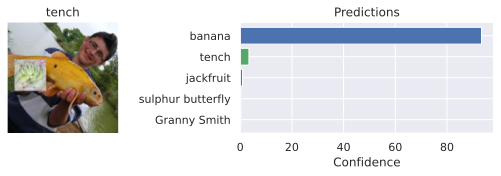

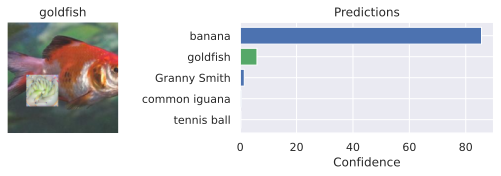

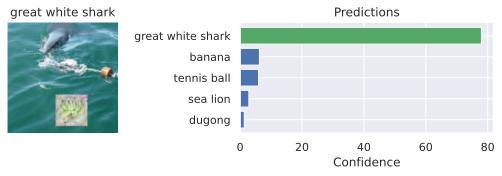

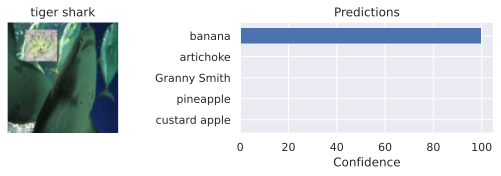

In [ ]:
perform_patch_attack(merge_patch_data)


In [ ]:
image_data = np.transpose(merge_patch_data, (1, 2, 0))

#Show and save the picture
plt.imshow(image_data)
plt.axis('off')
plt.savefig('merge_patch_data.png', bbox_inches='tight', pad_inches=0)
plt.close()